The purpose of this problem is to find the ideal targets and its weightings of a call center agent's scorecard. Scorecards are used to track the agent's performance (such as customer quality, save rate, first call resolution, average handle time, transfer percentage). <br>

In this exercise, i used a linear regression to model the relationship between all the different metrics and their impacts to average handle time, which is the most important metric and the upper management focuses on this the most. Once the model is determined, it is translated into an optimization function to determine for what values of the metrics, will yield the lowest average handle time. The lower the average handle time, the better it is in terms of cost savings. 

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv("BMSB_Metrics.csv")
df['Date'] = pd.to_datetime(df['Row Labels'])
df.index = df['Date']
df = df.drop(columns = ['Row Labels','Date'])
df = df['2018':'2019']
df.head()

,ABT,ADJUSTMENTS,BPI_OVERALL_FLOW_COMPLIANCE,CUSTOMER_SAVE_RATE_7,CUSTOMER_SAVE_RATE_DAY60_NL,FCR7,FIZZBACK_SAT,LEADS_PER_CONTACTS_TOTAL,TRANSFER_IMPACT_LEADS,FCR45
Date,,,,,,,,,,
2018-01-31,660.235360,1.922169,1.000000,0.942205,0.918784,0.820080,0.796027,0.015950,0.108299,0.532939
2018-02-28,565.349495,1.594460,1.000000,0.948879,0.941483,0.826016,0.822171,0.016286,0.097855,0.506132
2018-03-31,544.760639,1.507393,1.000000,0.945735,0.938949,0.824158,0.817490,0.017415,0.090683,0.498040
2018-04-30,539.364180,2.126434,1.000000,0.953866,0.940069,0.824352,0.817862,0.016807,0.091555,0.498968
2018-05-31,538.194868,4.004590,0.561822,0.948408,0.944513,0.824194,0.808113,0.017985,0.089879,0.494091


In [3]:
#find how many nan per column
df.isnull().sum()

ABT                            0
ADJUSTMENTS                    0
BPI_OVERALL_FLOW_COMPLIANCE    0
CUSTOMER_SAVE_RATE_7           0
CUSTOMER_SAVE_RATE_DAY60_NL    0
FCR7                           0
FIZZBACK_SAT                   0
LEADS_PER_CONTACTS_TOTAL       0
TRANSFER_IMPACT_LEADS          0
FCR45                          0
dtype: int64

In [4]:
#find how many zero per column
for i in df.columns:
    column_zero = np.where(df[i] == 0 ,1, 0)
    total = column_zero.sum(axis = 0)
    print(i,total)

ABT 0
ADJUSTMENTS 0
BPI_OVERALL_FLOW_COMPLIANCE 0
CUSTOMER_SAVE_RATE_7 0
CUSTOMER_SAVE_RATE_DAY60_NL 0
FCR7 0
FIZZBACK_SAT 0
LEADS_PER_CONTACTS_TOTAL 0
TRANSFER_IMPACT_LEADS 0
FCR45 0


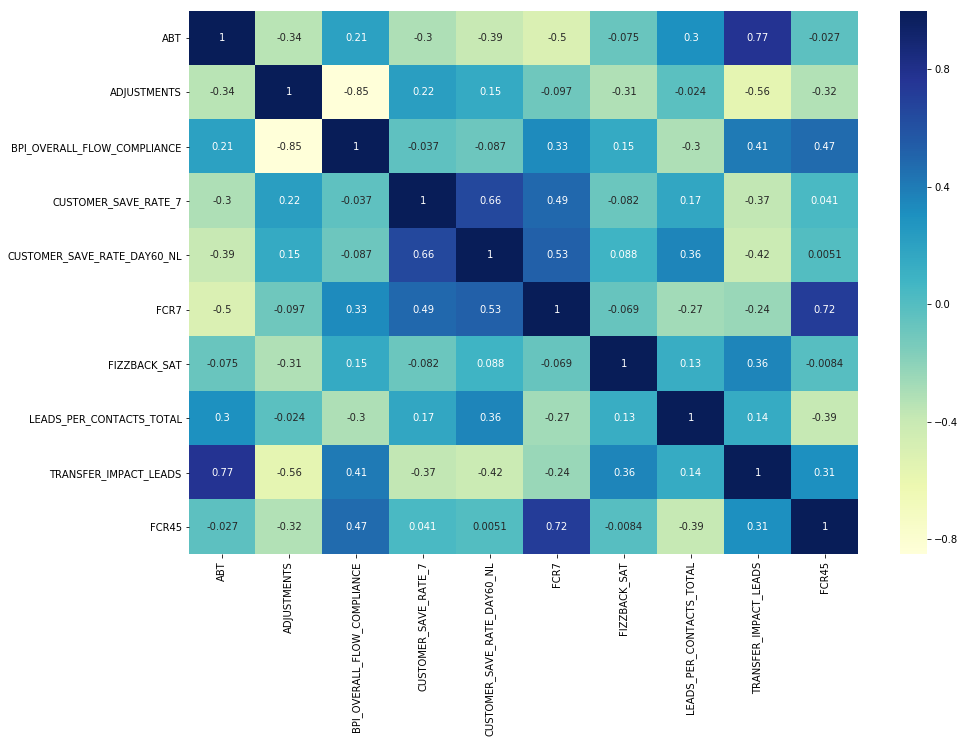

In [5]:
#find the correlation between each metric
fig, ax = plt.subplots(1,1,figsize = (15,10))
sns.heatmap(df.corr(), annot = True,cmap="YlGnBu")

In [6]:
#standardize the data
df_x = df.iloc[:,1:]
df_y = df.iloc[:,0]
preprocessing = StandardScaler()
x = preprocessing.fit_transform(df_x)
y = preprocessing.fit_transform(np.array(df_y).reshape(-1,1))
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=100)

In [7]:
#random forest
RF_model = RandomForestRegressor()
RF_model.fit(X_train,y_train)
score = RF_model.score(X_train,y_train)
print('The score of the random forest: ',score)

The score of the random forest:  0.932581161131811


C:\Users\aaronmok\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\aaronmok\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
names = df_x.columns
feat_import_df = pd.DataFrame({'Impact_on_ABT':RF_model.feature_importances_}, index = names)
feat_import_results = feat_import_df.sort_values(by = 'Impact_on_ABT',ascending = False)
feat_import_results['Impact_on_ABT'] = ["{0:.2f}%".format(val * 100) for val in feat_import_results['Impact_on_ABT']]

In [9]:
#the table below is used to determine the influence it has on the y value, which is average handle time. 
#As you can see, the more transfers and adjustment means higher average handle time
#while, fizzback (quality) and blueprints compliance has a lower influence

feat_import_results

,Impact_on_ABT
TRANSFER_IMPACT_LEADS,59.45%
CUSTOMER_SAVE_RATE_DAY60_NL,10.22%
ADJUSTMENTS,8.49%
FCR45,8.16%
FCR7,6.68%
FIZZBACK_SAT,2.03%
BPI_OVERALL_FLOW_COMPLIANCE,1.92%
CUSTOMER_SAVE_RATE_7,1.53%
LEADS_PER_CONTACTS_TOTAL,1.52%


In [10]:
#Linear Regression
LR_model = LinearRegression()
LR_model.fit(df_x,df_y)
score = LR_model.score(df_x,df_y)
print('The score of the linear regression: ',score)
coef = LR_model.coef_
intercept = LR_model.intercept_ 

The score of the linear regression:  0.8962650283469583


In [11]:
names

Index(['ADJUSTMENTS', 'BPI_OVERALL_FLOW_COMPLIANCE', 'CUSTOMER_SAVE_RATE_7',
       'CUSTOMER_SAVE_RATE_DAY60_NL', 'FCR7', 'FIZZBACK_SAT',
       'LEADS_PER_CONTACTS_TOTAL', 'TRANSFER_IMPACT_LEADS', 'FCR45'],
      dtype='object')

In [51]:
#optimization function

#Constaints
# $1.50 < ADJUSTMENTS < #3.00
# 80% < BPI_OVERALL_FLOW_COMPLIANCE < 100%
# 96% < CUSTOMER_SAVE_RATE_7 < 100%
# 94% < CUSTOMER_SAVE_RATE_DAY60_NL < 100%
# 80% < FCR7 < 90%
# 75% < FIZZBACK_SAT < 90%
# 1.5% < LEADS_PER_CONTACTS_TOTAL < 2.5%
# 10% < TRANSFER_IMPACT_LEADS < 20%
# 45% < FCR45 < 55%
# 450 < ABT

x0 = [1.5,0.8,0.75,0.75,0.75,0.75,0.015,0.1,0.5] 
results = minimize(lambda x: (x[0]*coef[0]) + (x[1]*coef[1]) + (x[2]*coef[2]) + (x[3]*coef[3]) + (x[4]*coef[4])\
          + (x[5]*coef[5]) + (x[6]*coef[6]) + (x[7]*coef[7]) + (x[8]*coef[8]) + intercept, x0, 
                   
    constraints = [{'type': 'ineq','fun': lambda x: (x[0] - 1.5)},
                   {'type': 'ineq','fun': lambda x: -(x[0] - 3)},
                   {'type': 'ineq','fun': lambda x: (x[1] - 0.80)},
                   {'type': 'ineq','fun': lambda x: -(x[1] - 1)},
                   {'type': 'ineq','fun': lambda x: (x[2] - 0.96)},
                   {'type': 'ineq','fun': lambda x: -(x[2] - 1)},
                   {'type': 'ineq','fun': lambda x: (x[3] - 0.94)},
                   {'type': 'ineq','fun': lambda x: -(x[3] - 1)},
                   {'type': 'ineq','fun': lambda x: (x[4] - 0.80)},
                   {'type': 'ineq','fun': lambda x: -(x[4] - 0.9)},
                   {'type': 'ineq','fun': lambda x: (x[5] - 0.75)},
                   {'type': 'ineq','fun': lambda x: -(x[5] - 0.9)},
                   {'type': 'ineq','fun': lambda x: (x[6] - 0.015)},
                   {'type': 'ineq','fun': lambda x: -(x[6] - 0.025)},
                   {'type': 'ineq','fun': lambda x: (x[7] - 0.1)},
                   {'type': 'ineq','fun': lambda x: -(x[7] - 0.2)},
                   {'type': 'ineq','fun': lambda x: (x[8] - 0.45)},
                   {'type': 'ineq','fun': lambda x: -(x[8] - 0.55)},
                  {'type': 'ineq','fun': lambda x: (x[0]*coef[0]) + (x[1]*coef[1]) + (x[2]*coef[2]) + (x[3]*coef[3]) + (x[4]*coef[4])\
                          + (x[5]*coef[5]) + (x[6]*coef[6]) + (x[7]*coef[7]) + (x[8]*coef[8]) + intercept - 500}],
                   
    method='SLSQP')

In [52]:
print("These are the optimized values: " ,results.x)
print("The optimized values will product handle time of: " ,results.fun)

These are the optimized values:  [1.49999991 0.79999866 0.96000257 0.93999076 0.86054536 0.80133732
 0.01497579 0.0998799  0.49041513]
The optimized values will product handle time of:  499.17405184878385


In [53]:
targets = pd.DataFrame({'Metric':names, 'New_Target':results.x})

In [50]:
#The table below finds what values (new targets) to set for the call center agents to follow 
#in order to minimize the average handle time.
targets

,Metric,New_Target
0,ADJUSTMENTS,1.500000
1,BPI_OVERALL_FLOW_COMPLIANCE,0.799999
2,CUSTOMER_SAVE_RATE_7,0.960003
3,CUSTOMER_SAVE_RATE_DAY60_NL,0.939991
4,FCR7,0.860545
5,FIZZBACK_SAT,0.801337
6,LEADS_PER_CONTACTS_TOTAL,0.014976
7,TRANSFER_IMPACT_LEADS,0.099880
8,FCR45,0.490415
